# <a id='toc1_'></a>[World University Rankings](#toc0_)

![logo_QS.png](attachment:logo_QS.png)

QS World University Rankings 2024: Top global universities

The 20th edition of the QS World University Rankings features 1,500 institutions across 104 locations and is the only ranking of its kind to emphasise employability and sustainability.

This year, we've implemented our largest-ever methodological enhancement, introducing three new metrics: Sustainability, Employment Outcomes and International Research Network. 

https://www.topuniversities.com/

**Table of contents**<a id='toc0_'></a>    
- [World University Rankings](#toc1_)    
    - [Open the data](#toc1_1_1_)    
    - [Clean the data](#toc1_1_2_)    
    - [Obtain the coordenates of the universities](#toc1_1_3_)    
    - [Export as .csv](#toc1_1_4_)    
    - [Create a map of the Universities with folium](#toc1_1_5_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

In [1]:
# Libraries
import pandas as pd
import pylab as plt
import seaborn as sns

# Extract coordenates
from geopy.geocoders import GoogleV3

# Draw maps
import folium
from folium.plugins import MarkerCluster

# Functions
import sys
sys.path.append('../src')
from support_clean import *

# Ignore Warnings
import warnings
warnings.filterwarnings('ignore')

### <a id='toc1_1_1_'></a>[Open the data](#toc0_)

In [2]:
universities = pd.read_excel('../data/universities/2024_QS_World_University_Rankings.xlsx')
universities.head()

,RANK_2024,RANK_2023,Institution Name,country,Location,SIZE,FOCUS,RES.,STATUS,Academic Reputation,Employer Reputation,Faculty Student,Citations per Faculty,International Faculty,International Students,International Research Network,Employment Outcomes,Sustainability,Overall
0,1,1,Massachusetts Institute of Technology (MIT),US,United States,M,CO,VH,B,100.0,100.0,100.0,100.0,100.0,88.2,94.3,100.0,95.2,100
1,2,2,University of Cambridge,UK,United Kingdom,L,FC,VH,A,100.0,100.0,100.0,92.3,100.0,95.8,99.9,100.0,97.3,99.2
2,3,4,University of Oxford,UK,United Kingdom,L,FC,VH,A,100.0,100.0,100.0,90.6,98.2,98.2,100.0,100.0,97.8,98.9
3,4,5,Harvard University,US,United States,L,FC,VH,B,100.0,100.0,98.3,100.0,84.6,66.8,100.0,100.0,96.7,98.3
4,5,3,Stanford University,US,United States,L,FC,VH,B,100.0,100.0,100.0,99.9,99.9,51.2,95.8,100.0,94.4,98.1


### <a id='toc1_1_2_'></a>[Clean the data](#toc0_)

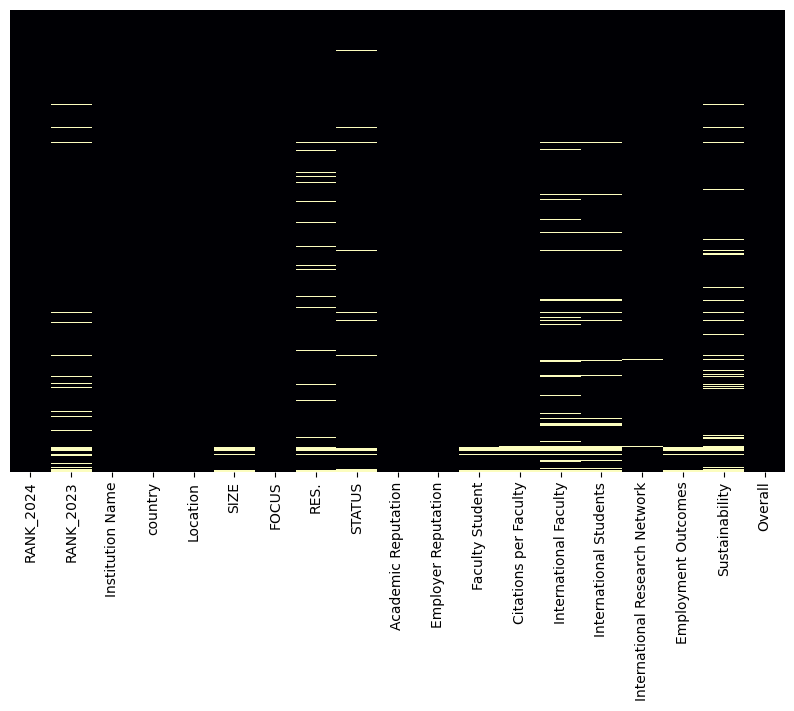

In [3]:
view_nan(universities)

In [4]:
# column RANK_2024 from object --> to integer

def clean_rank(x):

    if type(x) != int:
        x = x.replace('=', '').replace('+', '')
        return x.split('-')[0]
    
    else:
        return x

In [5]:
universities['RANK_2024'] = universities['RANK_2024'].apply(clean_rank)
universities['RANK_2024'] = pd.to_numeric(universities['RANK_2024']).astype('Int64')

In [6]:
# drop columns
columns_to_drop = ['RANK_2023',
                   'SIZE',
                   'RES.',
                   'FOCUS',
                   'STATUS',
                   'Employer Reputation',
                   'Faculty Student', 
                   'Citations per Faculty', 
                   'International Faculty', 
                   'International Students', 
                   'International Research Network', 
                   'Employment Outcomes', 
                   'Sustainability',
                   'Overall']

universities = universities.drop(columns = columns_to_drop)

In [7]:
column_name_mapping = {'RANK_2024': 'Rank_2024',
                       'Institution Name': 'Institution_Name',
                       'country': 'Country',
                       'Location': 'Location',
                       'Academic Reputation': 'Academic_Reputation'}

In [8]:
universities = universities.rename(columns=column_name_mapping)

### <a id='toc1_1_3_'></a>[Obtain the coordenates of the universities](#toc0_)

In [9]:
with open('../google_api_key.txt', 'r') as file:
    google_api_key = file.read().strip()

In [ ]:
university_names = universities['Institution_Name'].tolist()
locations = universities['Location'].tolist()
    
geolocator = GoogleV3(api_key= google_api_key)

latitudes = []
longitudes = []

for university, location in zip(university_names, locations):
    try:
        location_info = geolocator.geocode(f"{university}, {location}")
        latitudes.append(location_info.latitude)
        longitudes.append(location_info.longitude)
    except AttributeError:
        latitudes.append(None)
        longitudes.append(None)


universities['Latitude'] = latitudes
universities['Longitude'] = longitudes

### <a id='toc1_1_4_'></a>[Export as .csv](#toc0_)

In [52]:
universities.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1498 entries, 0 to 1497
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Rank_2024            1498 non-null   Int64  
 1   Institution_Name     1498 non-null   object 
 2   Country              1498 non-null   object 
 3   Location             1498 non-null   object 
 4   Academic_Reputation  1498 non-null   float64
 5   Latitude             1498 non-null   float64
 6   Longitude            1498 non-null   float64
dtypes: Int64(1), float64(3), object(3)
memory usage: 83.5+ KB


In [61]:
universities.to_csv('../data/universities_db.csv')

### <a id='toc1_1_5_'></a>[Create a map of the Universities with folium](#toc0_)

In [18]:
universities = pd.read_csv('../data/universities_db.csv', index_col=False)
universities.drop('Unnamed: 0', axis=1, inplace = True)

In [30]:
# help(folium.Map())

In [19]:
map_center = [universities['Latitude'].iloc[0], universities['Longitude'].iloc[0]]
my_map = folium.Map(location=map_center, zoom_start=10, tiles='cartodbdark_matter')
marker_cluster = MarkerCluster().add_to(my_map)

for index, row in universities.iterrows():
    university_name = row['Institution_Name']
    university_rank = row['Rank_2024']
    location = [row['Latitude'], row['Longitude']]
    icon_color = 'black'
    icon_name = 'fa-solid fa-building-columns'
    
# Other icons that I like and can be used for universities:
    # 'graduation-cap' 
    # 'fa-solid fa-skull'

    folium.Marker(location,
                  popup = f'{university_name} Rank: {university_rank}',
                  icon = folium.Icon(color=icon_color, 
                                     icon=f'fa-{icon_name}', 
                                     prefix='fa')).add_to(marker_cluster)

In [20]:
my_map.save('../html/universities_map.html')